In [510]:
# Have used plotty so please make sure to install below commands 
#!pip install plotly
#!pip install cufflinks

# Case Study : Car Price Prediction using Linear Regression 

### Problem Statement

>A Chinese automobile company Geely Auto aspires to enter the US market by setting up their manufacturing unit there and producing cars locally to give competition to their US and European counterparts.<br><br>
They have contracted an automobile consulting company to understand the factors on which the pricing of cars depends. Specifically, they want to understand the factors affecting the pricing of cars in the American market, since those may be very different from the Chinese market. <br>
The company wants to know:<br>
1. Which variables are significant in predicting the price of a car
2. How well those variables describe the price of a car<br><br>
Based on various market surveys, the consulting firm has gathered a large dataset of different types of cars across the Americal market.  <br>

### Business Goal 

>Is is required to model the price of cars with the available independent variables. It will be used by the management to understand how exactly the prices vary with the independent variables. They can accordingly manipulate the design of the cars, the business strategy etc. to meet certain price levels. Further, the model will be a good way for management to understand the pricing dynamics of a new market. 

----

### Loading Moduels & Libraries 

In [511]:
import pandas as pd
import numpy as np

import cufflinks as cf
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from scipy import special 
import matplotlib.pyplot as plt
import seaborn as sns
import math
from IPython.display import Markdown, display ,HTML
import statsmodels.api as sm # import API
from matplotlib.pyplot import xticks


sns.set(style="whitegrid")

pd.set_option('display.max_columns', 100)

py.offline.init_notebook_mode(connected=True) # plotting in offilne mode 
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')

pd.set_option('display.max_colwidth', -1) # make sure data and columns are displayed correctly withput purge
pd.options.display.float_format = '{:20,.2f}'.format # display float value with correct precision 

import warnings
warnings.filterwarnings('ignore')

### Meta Data Helper Utilities 

In [512]:
def log(string):
    display(Markdown("> <span style='color:blue'>"+string+"</span>"))

def header(string):
    display(Markdown("------ "))
    display(Markdown("### "+string))
    
def header_red(string):
    display(Markdown("> <span style='color:red'>"+string))   
    
def color_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for 65 %
    null values , black otherwise.
    """
    color = 'red' if val > 65 else 'black'
    return 'color: %s' % color  

def get_variable_type(element) :
    """
     Check is columns are of Contineous or Categorical variable.
     Assumption is that if 
                 unique count < 20 then categorical 
                 unique count >= 20 and dtype = [int64 or float64] then contineous
     """
    if element==0:
        return "Not Known"
    elif element < 20 and element!=0 :
        return "Categorical"
    elif element >= 20 and element!=0 :
        return "Contineous" 
    
def get_meta_data(dataframe) :
    """
     Method to get Meta-Data about any dataframe passed 
    """
    metadata_matrix = pd.DataFrame({
                    'Datatype' : dataframe.dtypes.astype(str), # data types of columns
                    'Non_Null_Count': dataframe.count(axis = 0).astype(int), # total elements in columns
                    'Null_Count': dataframe.isnull().sum().astype(int), # total null values in columns
                    'Null_Percentage': dataframe.isnull().sum()/len(dataframe) * 100, # percentage of null values
                    'Unique_Values_Count': dataframe.nunique().astype(int) # number of unique values
                     })
    
    metadata_matrix = predict_variable_type(metadata_matrix)
    return metadata_matrix
        
def display_columns_with_1_unique_value(dataframe):
    unique_values_count_1 = dataframe[dataframe["Unique_Values_Count"] == 1]
    drop_value_col = unique_values_count_1.index.tolist()
    lenght = len(drop_value_col)
    header("Columns with only one unique value : "+str(lenght))
    if lenght == 0 :
        header_red("No columns with only one unique values.")  
    else :    
        log("Columns with only one unique value :")
        for index,item in enumerate(drop_value_col) :
            print(index,".",item)
            
def predict_variable_type(metadata_matrix):
    metadata_matrix["Variable_Type"] = metadata_matrix["Unique_Values_Count"].apply(get_variable_type).astype(str)
    metadata_matrix["frequency"] = metadata_matrix["Null_Count"] - metadata_matrix["Null_Count"]
    metadata_matrix["frequency"].astype(int)
    return metadata_matrix 


def list_potential_categorical_type(dataframe,main) :
    header("Stats for potential Categorical datatype columns")
    metadata_matrix_categorical = dataframe[dataframe["Variable_Type"] == "Categorical"]
    # TO DO *** Add check to skip below if there is no Categorical values 
    length = len(metadata_matrix_categorical)
    if length == 0 :
        header_red("No Categorical columns in given dataset.")  
    else :    
        metadata_matrix_categorical = metadata_matrix_categorical.filter(["Datatype","Unique_Values_Count"])
        metadata_matrix_categorical.sort_values(["Unique_Values_Count"], axis=0,ascending=False, inplace=True)
        col_to_check = metadata_matrix_categorical.index.tolist()
        name_list = []
        values_list = []
        for name in col_to_check :
            name_list.append(name)
            values_list.append(main[name].unique())
        temp = pd.DataFrame({"index":name_list,"Unique_Values":values_list})
        metadata_matrix_categorical = metadata_matrix_categorical.reset_index()
        metadata_matrix_categorical = pd.merge(metadata_matrix_categorical,temp,how='inner',on='index')
        display(metadata_matrix_categorical.set_index("index")) 
        
def get_potential_categorical_type(dataframe,main,unique_count) :
    metadata_matrix_categorical = dataframe[dataframe["Variable_Type"] == "Categorical"]
    metadata_matrix_categorical = dataframe[dataframe["Unique_Values_Count"] == unique_count]
    length = len(metadata_matrix_categorical)
    if length == 0 :
        header_red("No Categorical columns in given dataset.")  
    else :    
        metadata_matrix_categorical = metadata_matrix_categorical.filter(["Datatype","Unique_Values_Count"])
        metadata_matrix_categorical.sort_values(["Unique_Values_Count"], axis=0,ascending=False, inplace=True)
        col_to_check = metadata_matrix_categorical.index.tolist()
        name_list = []
        values_list = []
        for name in col_to_check :
            name_list.append(name)
            values_list.append(main[name].unique())
        temp = pd.DataFrame({"index":name_list,"Unique_Values":values_list})
        metadata_matrix_categorical = metadata_matrix_categorical.reset_index()
        metadata_matrix_categorical = pd.merge(metadata_matrix_categorical,temp,how='inner',on='index')
        display(metadata_matrix_categorical.set_index("index")) 
        
def plot_data_type_pie_chat(dataframe) : 
    header("Stats for Datatype Percentage Distribution")
    dataframe_group = dataframe.groupby("Datatype").frequency.count().reset_index()
    dataframe_group.sort_values(["Datatype"], axis=0,ascending=False, inplace=True)
    trace = go.Pie(labels=dataframe_group["Datatype"].tolist(), values=dataframe_group["frequency"].tolist())
    layout = go.Layout(title="Datatype Percentage Distribution")
    fig = go.Figure(data=[trace], layout=layout)    
    py.offline.iplot(fig)
    
def pairplot(x_axis,y_axis) :
    sns.pairplot(car_df,x_vars=x_axis,y_vars=y_axis,height=4,aspect=1,kind="scatter")
    plt.show()

def heatmap(x,y,dataframe):
    plt.figure(figsize=(x,y))
    sns.heatmap(dataframe.corr(),cmap="OrRd",annot=True)
    plt.show()
        
def plot_box_chart(dataframe) :
    data = []
    for index, column_name in enumerate(dataframe) :
        data.append(
        go.Box(y=dataframe.iloc[:, index],name=column_name))   
        
    layout = go.Layout(yaxis=dict(title="Frequency",zeroline=False),boxmode='group')
    fig = go.Figure(data=data, layout=layout)    
    py.offline.iplot(fig)    
    
def bar_count_plot(dataframe,col_name) :
    plt.figure(figsize=(16,8))
    plt.title(col_name + 'Histogram')
    sns.countplot(car_df[col_name], palette=("plasma"))
    xticks(rotation = 90)
    plt.show()
    
def color_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for value 
    greater than 10 , black otherwise.
    """
    color = 'red' if val > 5 else 'black'
    return 'color: %s' % color

def color_code_vif_values(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for 10
    , black otherwise.
    """
    if val > 10 : color = 'red' 
    elif val > 5 and val <= 10 : color = 'blue'
    elif val > 0 and val <= 5 : color = 'darkgreen'
    else : color = 'black'
    return 'color: %s' % color

def drop_col(dataframe,col_to_drop) :
    dataframe.drop([col_to_drop],axis=1,inplace=True)
    return dataframe

# Loading dataset for car price analysis

In [513]:
encoding_latin="latin"
car_df = pd.read_csv("CarPrice_Assignment.csv",low_memory = False,encoding = encoding_latin)
car_df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.60,168.80,64.10,48.80,2548,dohc,four,130,mpfi,3.47,2.68,9.00,111,5000,21,27,"13,495.00"
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.60,168.80,64.10,48.80,2548,dohc,four,130,mpfi,3.47,2.68,9.00,111,5000,21,27,"16,500.00"
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.50,171.20,65.50,52.40,2823,ohcv,six,152,mpfi,2.68,3.47,9.00,154,5000,19,26,"16,500.00"
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.80,176.60,66.20,54.30,2337,ohc,four,109,mpfi,3.19,3.40,10.00,102,5500,24,30,"13,950.00"
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.40,176.60,66.40,54.30,2824,ohc,five,136,mpfi,3.19,3.40,8.00,115,5500,18,22,"17,450.00"


In [514]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
car_ID              205 non-null int64
symboling           205 non-null int64
CarName             205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm      

> <span style='color:blue'>**Analysis** - Dataset is clean and no NaN susbtitution is required</span>

## Meta data analysis for loaded dataset

In [515]:
metadata_matrix_dataframe = get_meta_data(car_df)

# 1. Columns List with only 1 unique values
display_columns_with_1_unique_value(metadata_matrix_dataframe)

# 2. Display Data Type percenatges 
plot_data_type_pie_chat(metadata_matrix_dataframe)

# 3. Potential Categorical Variable columns 
list_potential_categorical_type(metadata_matrix_dataframe,car_df)

------ 

### Columns with only one unique value : 0

> <span style='color:red'>No columns with only one unique values.

------ 

### Stats for Datatype Percentage Distribution

------ 

### Stats for potential Categorical datatype columns

,Datatype,Unique_Values_Count,Unique_Values
index,,,
fuelsystem,object,8,"[mpfi, 2bbl, mfi, 1bbl, spfi, 4bbl, idi, spdi]"
enginetype,object,7,"[dohc, ohcv, ohc, l, rotor, ohcf, dohcv]"
cylindernumber,object,7,"[four, six, five, three, twelve, two, eight]"
symboling,int64,6,"[3, 1, 2, 0, -1, -2]"
carbody,object,5,"[convertible, hatchback, sedan, wagon, hardtop]"
drivewheel,object,3,"[rwd, fwd, 4wd]"
fueltype,object,2,"[gas, diesel]"
aspiration,object,2,"[std, turbo]"
doornumber,object,2,"[two, four]"


# Data Cleanup / Rectification of existing values
> 1. Looking at the above dataset we need **not to replace any nan/null values** as our data is cleaned. 
2. But if we look at categorical values we see <b>drivewheel</b> columns which has values rwd, fwd, 4wd. Out of these fwd & 4wd represnt same values and hence 4wd needs to be susbtitued with fwd. 
3. Create out new columns with as **CarManufacturer** using **CarName** columns.
4. Drop column - car_ID as it will not add any value.

In [516]:
car_df["CarCompany"] = car_df["CarName"].apply(lambda carName : carName.split(" ")[0].title())
car_df = car_df.replace(to_replace ="4wd", value ="fwd") 

# Dropping car name as it will not add any values for our price prediction 
car_df.drop(["CarName"],axis=1,inplace=True)
car_df.drop(["car_ID"],axis=1,inplace=True)

In [517]:
car_df["CarCompany"].unique()

array(['Alfa-Romero', 'Audi', 'Bmw', 'Chevrolet', 'Dodge', 'Honda',
       'Isuzu', 'Jaguar', 'Maxda', 'Mazda', 'Buick', 'Mercury',
       'Mitsubishi', 'Nissan', 'Peugeot', 'Plymouth', 'Porsche',
       'Porcshce', 'Renault', 'Saab', 'Subaru', 'Toyota', 'Toyouta',
       'Vokswagen', 'Volkswagen', 'Vw', 'Volvo'], dtype=object)

**Looking at above data we found that few company names are same but are misspelt.** <br>
`1. 'Maxda', 'Mazda' --> Mazda`<br>
`2. 'Porsche','Porcshce' --> Porsche`<br>
`3. 'Toyota', 'Toyouta' --> Toyota`<br>
`4. 'Vokswagen', 'Volkswagen' --> Volkswagen`<br>
`5. 'Vw','Volvo' --> Volvo`<br>

In [518]:
car_df = car_df.replace(to_replace ="Maxda", value ="Mazda") 
car_df = car_df.replace(to_replace ="Porcshce", value ="Porsche") 
car_df = car_df.replace(to_replace ="Toyouta", value ="Toyota") 
car_df = car_df.replace(to_replace ="Vokswagen", value ="Volkswagen") 
car_df = car_df.replace(to_replace ="Vw", value ="Volvo") 

In [519]:
car_df.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,CarCompany
0,3,gas,std,two,convertible,rwd,front,88.60,168.80,64.10,48.80,2548,dohc,four,130,mpfi,3.47,2.68,9.00,111,5000,21,27,"13,495.00",Alfa-Romero
1,3,gas,std,two,convertible,rwd,front,88.60,168.80,64.10,48.80,2548,dohc,four,130,mpfi,3.47,2.68,9.00,111,5000,21,27,"16,500.00",Alfa-Romero
2,1,gas,std,two,hatchback,rwd,front,94.50,171.20,65.50,52.40,2823,ohcv,six,152,mpfi,2.68,3.47,9.00,154,5000,19,26,"16,500.00",Alfa-Romero
3,2,gas,std,four,sedan,fwd,front,99.80,176.60,66.20,54.30,2337,ohc,four,109,mpfi,3.19,3.40,10.00,102,5500,24,30,"13,950.00",Audi
4,2,gas,std,four,sedan,fwd,front,99.40,176.60,66.40,54.30,2824,ohc,five,136,mpfi,3.19,3.40,8.00,115,5500,18,22,"17,450.00",Audi


# Reading and Understanding the Data
> **Dependent Variable**
- Visualization of  Price

> **Independent Variable**
- Visualising Numeric Variables
- Visualising Categorical Variables


### Dependent Variable

In [520]:
plot_box_chart(pd.DataFrame(car_df["price"]))
log("**Analysis** : Price field has median around 10K with most expensive car values at 45k and cheapest car is 5k")

> <span style='color:blue'>**Analysis** : Price field has median around 10K with most expensive car values at 45k and cheapest car is 5k</span>

### Independent Variable

#### 1. Visualising Numeric Variables
- Analyizing trends by looking pairplot of all the **Independent variables Vs Dependent variable**.

In [521]:
car_df_describe = car_df.describe()
display(car_df_describe)

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00
mean,0.83,98.76,174.05,65.91,53.72,"2,555.57",126.91,3.33,3.26,10.14,104.12,"5,125.12",25.22,30.75,"13,276.71"
std,1.25,6.02,12.34,2.15,2.44,520.68,41.64,0.27,0.31,3.97,39.54,476.99,6.54,6.89,"7,988.85"
min,-2.00,86.60,141.10,60.30,47.80,"1,488.00",61.00,2.54,2.07,7.00,48.00,"4,150.00",13.00,16.00,"5,118.00"
25%,0.00,94.50,166.30,64.10,52.00,"2,145.00",97.00,3.15,3.11,8.60,70.00,"4,800.00",19.00,25.00,"7,788.00"
50%,1.00,97.00,173.20,65.50,54.10,"2,414.00",120.00,3.31,3.29,9.00,95.00,"5,200.00",24.00,30.00,"10,295.00"
75%,2.00,102.40,183.10,66.90,55.50,"2,935.00",141.00,3.58,3.41,9.40,116.00,"5,500.00",30.00,34.00,"16,503.00"
max,3.00,120.90,208.10,72.30,59.80,"4,066.00",326.00,3.94,4.17,23.00,288.00,"6,600.00",49.00,54.00,"45,400.00"


#### Plotting Pair Plot for better visualizations 

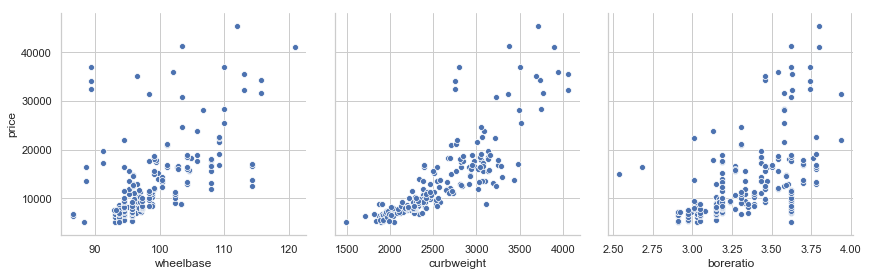

> <span style='color:blue'>**Analysis** : Wheelbase and Curbweight are **positively** correlated but gets spread out at higer values.</span>

In [522]:
y_vars=['price']
x_vars=['wheelbase','curbweight','boreratio']
pairplot(x_vars,y_vars)
log("**Analysis** : Wheelbase and Curbweight are **positively** correlated but gets spread out at higer values.")

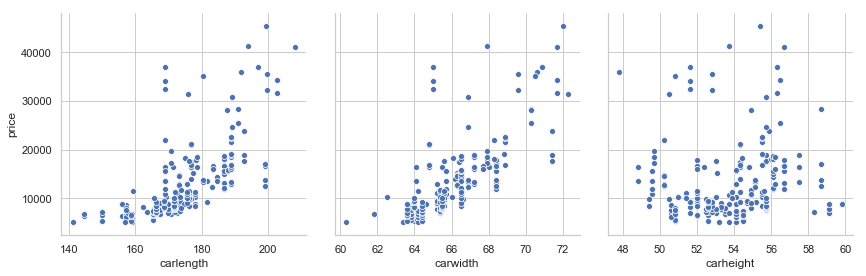

> <span style='color:blue'>**Analysis** : Carlength & Carwidth are more correlated compared to carheight which is more spreadout but **positive**.</span>

In [523]:
x_vars=['carlength','carwidth', 'carheight']
pairplot(x_vars,y_vars)
log("**Analysis** : Carlength & Carwidth are more correlated compared to carheight which is more spreadout but **positive**.")


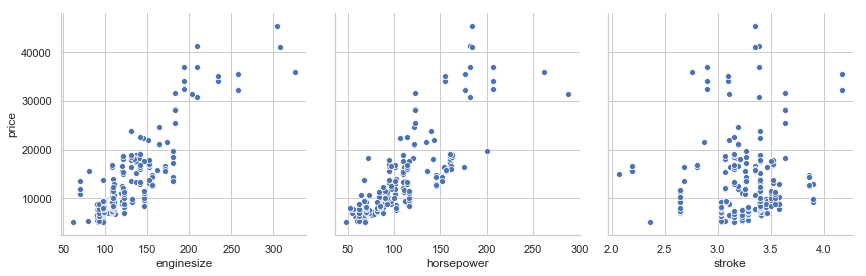

> <span style='color:blue'>**Analysis** : Enginesize & Horsepower are **postively** correlated but Stroke is more spread out(might not be related).</span>

In [524]:
x_vars=['enginesize','horsepower','stroke']
pairplot(x_vars,y_vars)
log("**Analysis** : Enginesize & Horsepower are **postively** correlated but Stroke is more spread out(might not be related).")


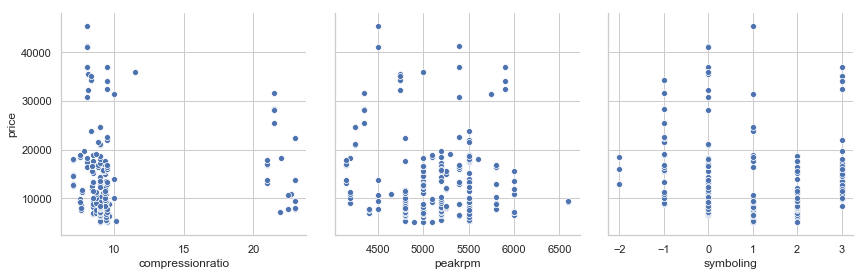

> <span style='color:blue'>**Analysis** : Compressionratio and Peakrpm is **not** correlated.</span>

In [525]:
x_vars=['compressionratio','peakrpm',"symboling"]
pairplot(x_vars,y_vars)
log("**Analysis** : Compressionratio and Peakrpm is **not** correlated.")

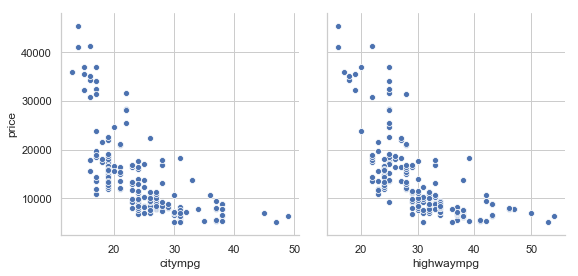

> <span style='color:blue'>**Analysis** : Citympg & Highwaympg is **negative** correlated, cheaper cars have better milage compare to expensive ones.</span>

In [526]:
x_vars=['citympg', 'highwaympg']
pairplot(x_vars,y_vars)

log("**Analysis** : Citympg & Highwaympg is **negative** correlated, cheaper cars have better milage compare to expensive ones.")


#### Plotting heatmap for numeric variables

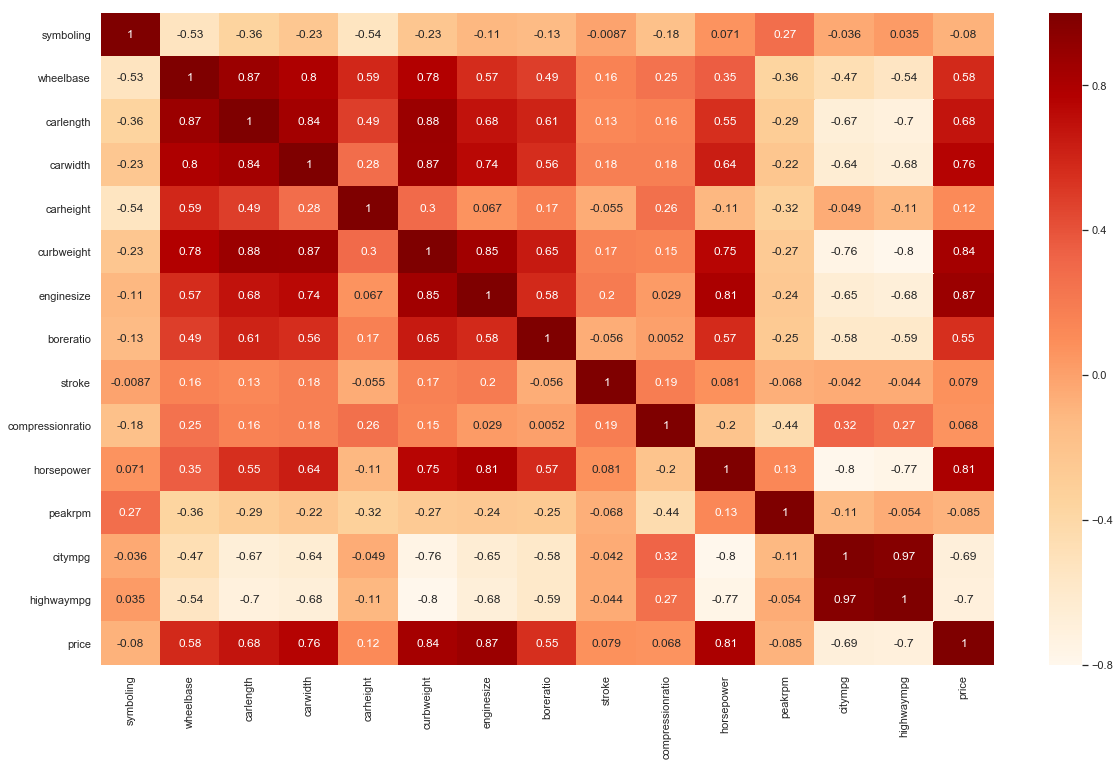

In [527]:
heatmap(20,12,car_df)

> <span style='color:blue'> **Analysis** : Looking at the above heat map we can see that above inferenses drawn between price and other features holds true.<br> Positive Relation with Price : wheelbase,carlenght,carwidth,curbweight,enginesize,boreratio,horesepower
</span>

#### Checking Multicolinearity b/w Independent variable

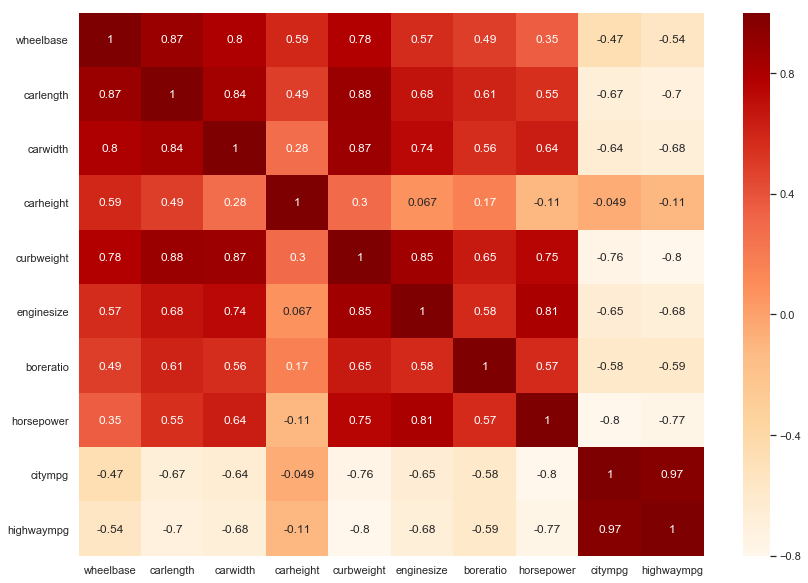

In [528]:
independent_col_list = ['wheelbase', 'carlength', 'carwidth', 'carheight','curbweight', 
                        'enginesize','boreratio','horsepower','citympg', 'highwaympg']

heatmap(14,10,car_df.filter(independent_col_list))

> <span style='color:blue'>**Analysis** : **citympg and highwaympg** have highest dependent (0.97) on each other and we have to keep track of them to avoid issues with muticoliniarity.</span>

### Group independent varible for correlation analysis

**1. Looking at correlation between Car Dimensions Specific Variable i.e. weight , height etc**

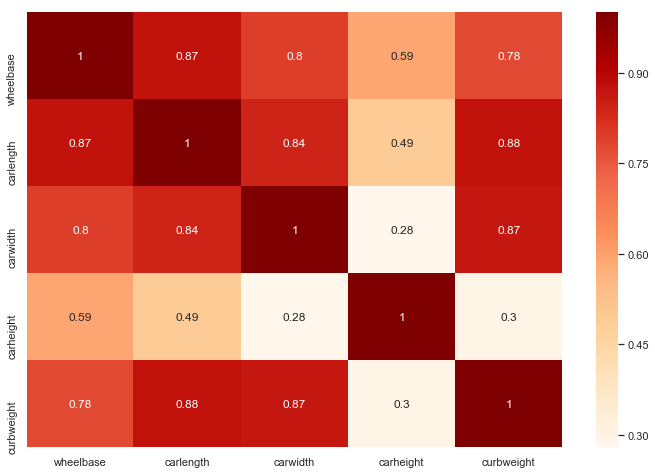

In [529]:
dimension_col_list = ['wheelbase', 'carlength', 'carwidth', 'carheight','curbweight']
heatmap(12,8,car_df.filter(dimension_col_list))

> <span style='color:blue'>**Analysis** : **Wheelbase , carlength , carwidth and carweight [ 0.80 - 0.88 ]** are higly correlated and we have to select one out of them. Carheight is not correlated and will not affect model buildingin negative way</span>

**2. Looking at correlation between Car Performance Specifc Varibale**

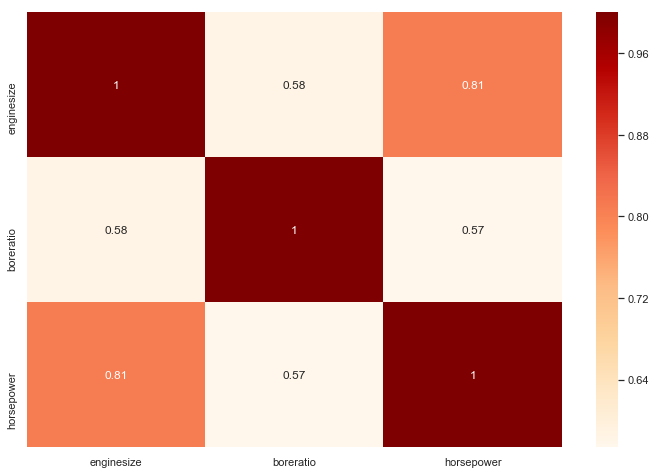

In [530]:
performance_col_list = ['enginesize','boreratio','horsepower']
heatmap(12,8,car_df.filter(performance_col_list))

> <span style='color:blue'>**Analysis** : **Horsepower** and **enginesize** are highly correlated and we need to select one from them. Boreratio is not related as will be included in model building</span>

#### 2. Visualising Categorical Variables

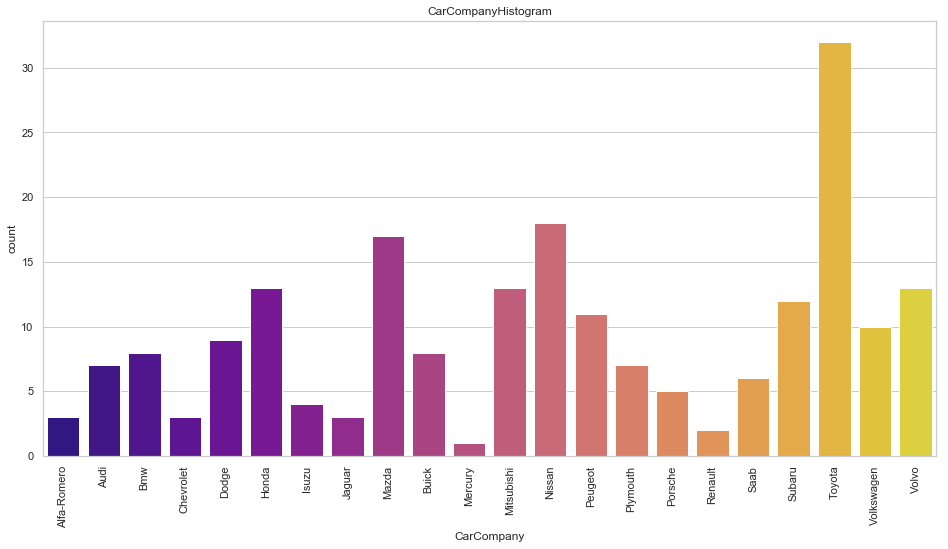

> <span style='color:blue'>**Analysis** : Looking at above graph **Toyota** seems to be really popular among car company followed Nissan and Mazda.</span>

In [531]:
bar_count_plot(car_df,"CarCompany")
log("**Analysis** : Looking at above graph **Toyota** seems to be really popular among car company followed Nissan and Mazda.")

In [532]:
# internal function written by me for better visualizatoin and understanding
metadata_matrix_dataframe = get_meta_data(car_df)
list_potential_categorical_type(metadata_matrix_dataframe,car_df)

------ 

### Stats for potential Categorical datatype columns

,Datatype,Unique_Values_Count,Unique_Values
index,,,
fuelsystem,object,8,"[mpfi, 2bbl, mfi, 1bbl, spfi, 4bbl, idi, spdi]"
enginetype,object,7,"[dohc, ohcv, ohc, l, rotor, ohcf, dohcv]"
cylindernumber,object,7,"[four, six, five, three, twelve, two, eight]"
symboling,int64,6,"[3, 1, 2, 0, -1, -2]"
carbody,object,5,"[convertible, hatchback, sedan, wagon, hardtop]"
fueltype,object,2,"[gas, diesel]"
aspiration,object,2,"[std, turbo]"
doornumber,object,2,"[two, four]"
drivewheel,object,2,"[rwd, fwd]"


**Looking at the above table , we can see below columns have two unique values**
>1. fueltype
2. aspiration
3. doornumber
4. drivewheel
5. enginelocation 


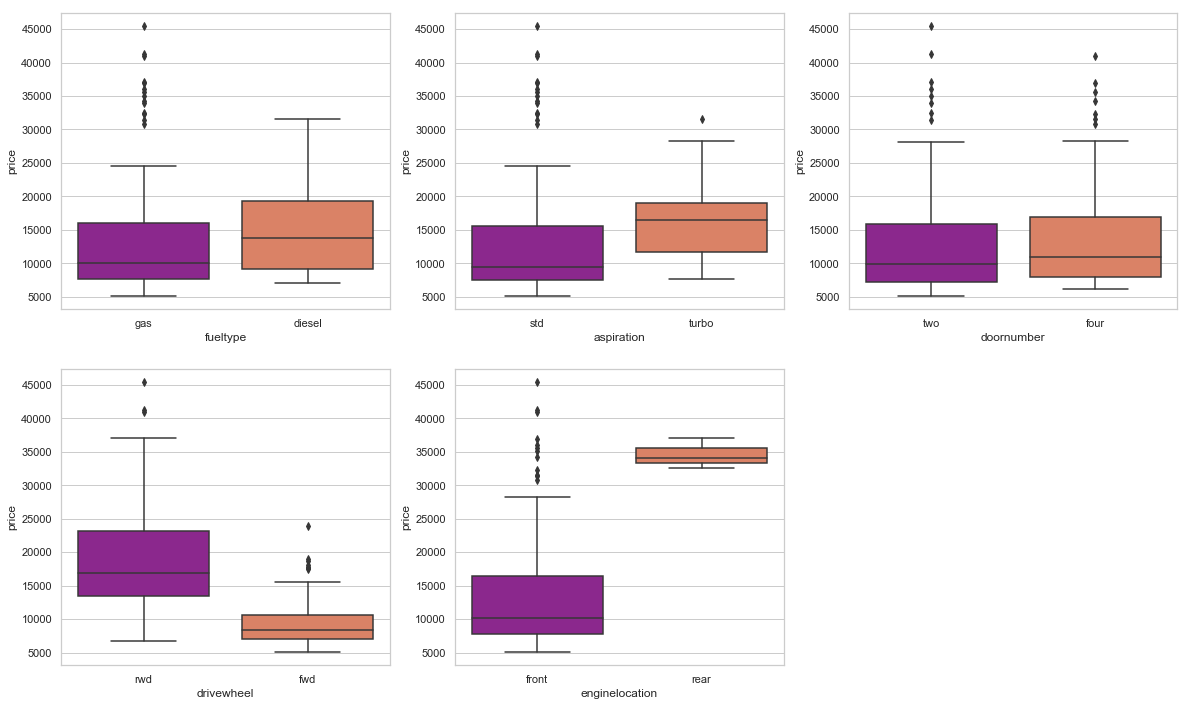

In [533]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x = 'fueltype', y = 'price', data = car_df, palette=("plasma"))
plt.subplot(2,3,2)
sns.boxplot(x = 'aspiration', y = 'price', data = car_df, palette=("plasma"))
plt.subplot(2,3,3)
sns.boxplot(x = 'doornumber', y = 'price', data = car_df ,palette=("plasma"))
plt.subplot(2,3,4)
sns.boxplot(x = 'drivewheel', y = 'price', data = car_df , palette=("plasma"))
plt.subplot(2,3,5)
sns.boxplot(x = 'enginelocation', y = 'price', data = car_df , palette=("plasma"))
plt.show()

><span style='color:blue'>**Analysis :** <br>Average price of diesel car are more expensive than gas but gas have more expensive car range.<br>
>Cars with turbo aspiration have generally expensive.<br>
>Most expensive cars have two doors.<br>
>Rear engine cars are more expensive than front engine location <br></span>

#### Looking at the above table , we can see other varible and checkig any correlatoin between them and price

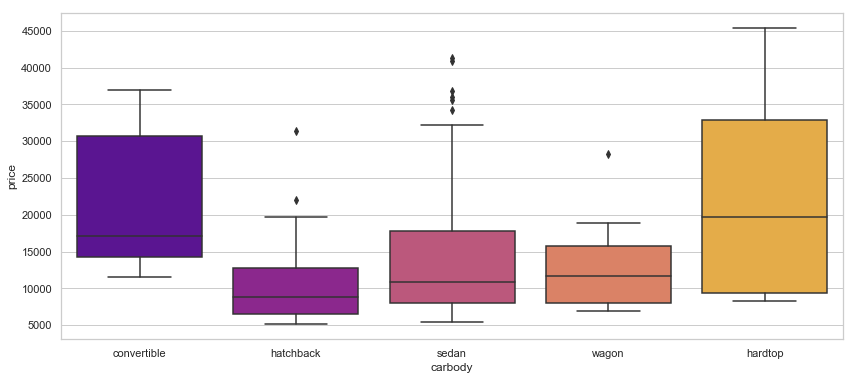

> <span style='color:blue'>**Analysis** : Hardtop is a clear winner and is the preffered choice among other.</span>

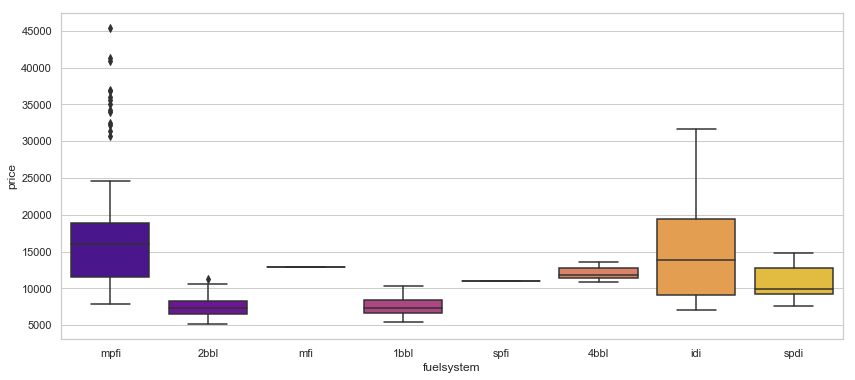

> <span style='color:blue'>**Analysis** : MPFI is the most common one among cars.</span>

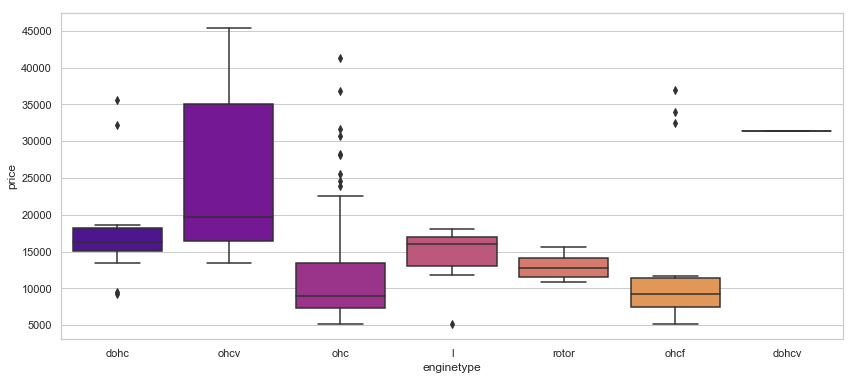

> <span style='color:blue'>**Analysis** : ohcv is the most common engine type.</span>

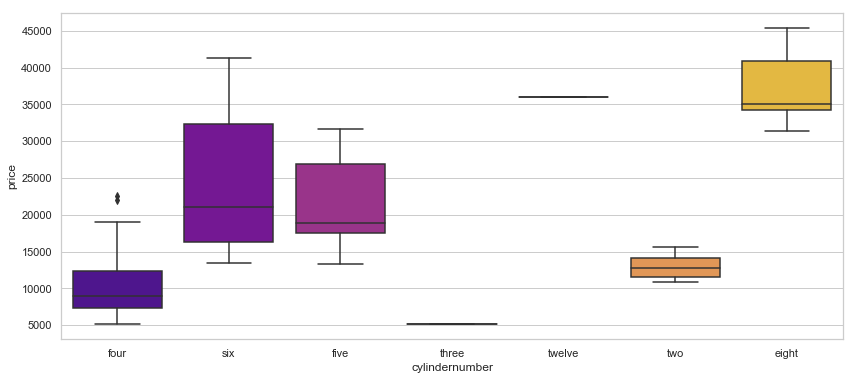

> <span style='color:blue'>**Analysis** : Expensive cars have Eight cylinder , four cylinder are the cheapest one.</span>

In [534]:
plt.figure(figsize=(14,6))
sns.boxplot(x='carbody',y='price',data = car_df, palette=("plasma"))
plt.show()
log("**Analysis** : Hardtop is a clear winner and is the preffered choice among other.")

plt.figure(figsize=(14,6))
sns.boxplot(x='fuelsystem',y='price',data = car_df, palette=("plasma"))
plt.show()
log("**Analysis** : MPFI is the most common one among cars.")

plt.figure(figsize=(14,6))
sns.boxplot(x='enginetype',y='price',data = car_df,palette=("plasma"))
plt.show()
log("**Analysis** : ohcv is the most common engine type.")

plt.figure(figsize=(14,6))
sns.boxplot(x='cylindernumber',y='price',data = car_df,palette=("plasma"))
plt.show()
log("**Analysis** : Expensive cars have Eight cylinder , four cylinder are the cheapest one.")


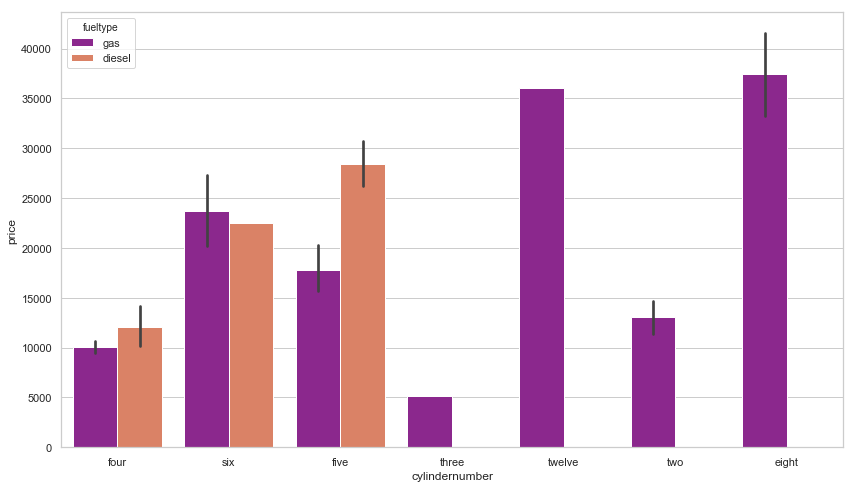

> <span style='color:blue'>**Analysis** : Not all cars comes in both gas and diesel variants. Cars with cylinder four,six and five have both variants.</span>

In [535]:
plt.figure(figsize=(14,8))
sns.barplot(x = 'cylindernumber', y = 'price', hue = 'fueltype',data = car_df,palette=("plasma"))
plt.show()
log("**Analysis** : Not all cars comes in both gas and diesel variants. Cars with cylinder four,six and five have both variants.")


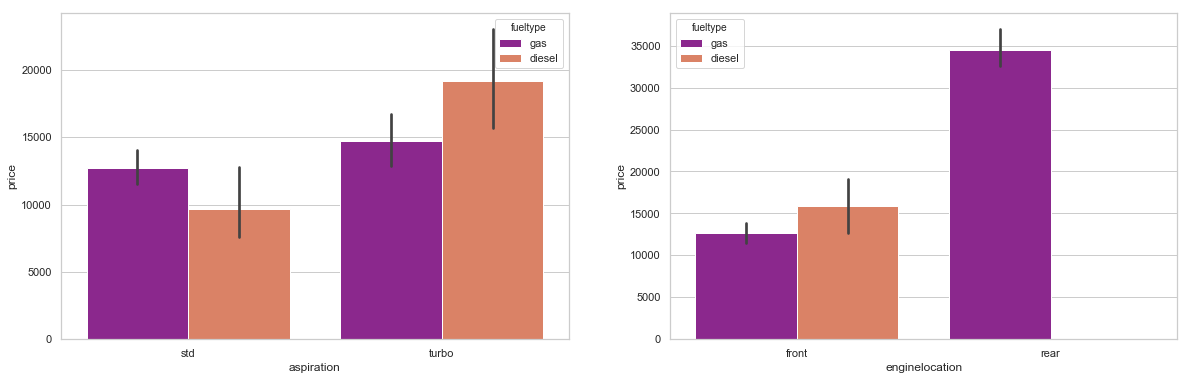

> <span style='color:blue'>**Analysis** : Can with rear engine dosent have any diesel models. Turo mode is more prevalent in diesel.</span>

In [536]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.barplot(x = 'aspiration', y = 'price', hue = 'fueltype',data = car_df,palette=("plasma"))

plt.subplot(1,2,2)
sns.barplot(x = 'enginelocation', y = 'price', hue = 'fueltype',data = car_df,palette=("plasma"))
plt.show()

log("**Analysis** : Can with rear engine dosent have any diesel models. Turo mode is more prevalent in diesel.")


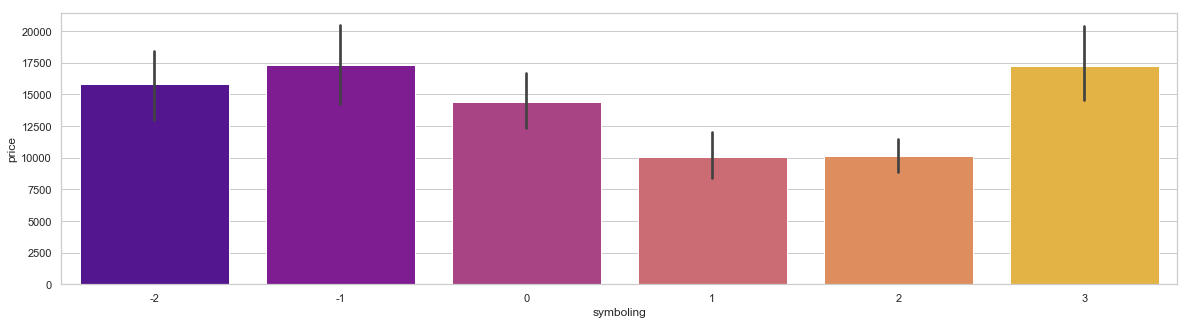

> <span style='color:blue'>**Analysis** : Top categories for car symboling is -1 and 3. </span>

In [537]:
plt.figure(figsize=(20,5))
sns.barplot(x = 'symboling', y = 'price',data = car_df,palette=("plasma"))
plt.show()
log("**Analysis** : Top categories for car symboling is -1 and 3. ")


# Data Preparation

> 1. You can see that your dataset has many columns with values only two values.
2. But in order to fit a regression line, we would need numerical values and not string. Hence, we need to convert them to 1s and 0s accordingly.
3. Convert higer categorical variables using **Dummy Variables**

In [538]:
metadata_matrix_dataframe = get_meta_data(car_df)
get_potential_categorical_type(metadata_matrix_dataframe,car_df,2)

,Datatype,Unique_Values_Count,Unique_Values
index,,,
fueltype,object,2,"[gas, diesel]"
aspiration,object,2,"[std, turbo]"
doornumber,object,2,"[two, four]"
drivewheel,object,2,"[rwd, fwd]"
enginelocation,object,2,"[front, rear]"


**Looking at the above table ,we can have to covert below columns in 1's and 0's**
>1. fueltype   {"gas": 1, "diesel": 0}
2. aspiration {"std": 1, "turbo": 0}
3. doornumber {"two": 1, "four": 0}
4. drivewheel {"rwd": 1, "fwd": 0}
5. enginelocation {"front": 1, "rear": 0}

In [539]:
def binary_dummy_replace(x) :
     return x.map({"gas":1,"diesel":0,
                   "std":1,"turbo":0,
                   "two":1, "four":0,
                   "rwd": 1, "fwd": 0,
                   "front": 1, "rear": 0})

In [540]:
col_to_replace =  ["fueltype","aspiration","doornumber","drivewheel","enginelocation"]
car_df[col_to_replace] = car_df[col_to_replace].apply(binary_dummy_replace)

car_df.head(2)

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,CarCompany
0,3,1,1,1,convertible,1,1,88.60,168.80,64.10,48.80,2548,dohc,four,130,mpfi,3.47,2.68,9.00,111,5000,21,27,"13,495.00",Alfa-Romero
1,3,1,1,1,convertible,1,1,88.60,168.80,64.10,48.80,2548,dohc,four,130,mpfi,3.47,2.68,9.00,111,5000,21,27,"16,500.00",Alfa-Romero


### Dummy Variables

In [541]:
def create_dummy_variable(dataframe,column_name):
    dummy_values = pd.get_dummies(dataframe[column_name],drop_first=True)
    dataframe = pd.concat([dataframe,dummy_values],axis=1)
    dataframe.drop([column_name],axis=1,inplace=True)
    return dataframe

In [542]:
metadata_matrix_dataframe = get_meta_data(car_df)
list_potential_categorical_type(metadata_matrix_dataframe,car_df)

------ 

### Stats for potential Categorical datatype columns

,Datatype,Unique_Values_Count,Unique_Values
index,,,
fuelsystem,object,8,"[mpfi, 2bbl, mfi, 1bbl, spfi, 4bbl, idi, spdi]"
enginetype,object,7,"[dohc, ohcv, ohc, l, rotor, ohcf, dohcv]"
cylindernumber,object,7,"[four, six, five, three, twelve, two, eight]"
symboling,int64,6,"[3, 1, 2, 0, -1, -2]"
carbody,object,5,"[convertible, hatchback, sedan, wagon, hardtop]"
fueltype,int64,2,"[1, 0]"
aspiration,int64,2,"[1, 0]"
doornumber,int64,2,"[1, 0]"
drivewheel,int64,2,"[1, 0]"


#### Creating dummy variables

In [543]:
car_df = create_dummy_variable(car_df,"carbody")
car_df = create_dummy_variable(car_df,"cylindernumber")
car_df = create_dummy_variable(car_df,"enginetype")
car_df = create_dummy_variable(car_df,"fuelsystem")
car_df = create_dummy_variable(car_df,"CarCompany")
car_df.head(2)

,symboling,fueltype,aspiration,doornumber,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,hardtop,hatchback,sedan,wagon,five,four,six,three,twelve,two,dohcv,l,ohc,ohcf,ohcv,rotor,2bbl,4bbl,idi,mfi,mpfi,spdi,spfi,Audi,Bmw,Buick,Chevrolet,Dodge,Honda,Isuzu,Jaguar,Mazda,Mercury,Mitsubishi,Nissan,Peugeot,Plymouth,Porsche,Renault,Saab,Subaru,Toyota,Volkswagen,Volvo
0,3,1,1,1,1,1,88.60,168.80,64.10,48.80,2548,130,3.47,2.68,9.00,111,5000,21,27,"13,495.00",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,1,1,1,1,1,88.60,168.80,64.10,48.80,2548,130,3.47,2.68,9.00,111,5000,21,27,"16,500.00",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [544]:
car_df_describe = car_df.describe()
display(car_df_describe)

,symboling,fueltype,aspiration,doornumber,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,hardtop,hatchback,sedan,wagon,five,four,six,three,twelve,two,dohcv,l,ohc,ohcf,ohcv,rotor,2bbl,4bbl,idi,mfi,mpfi,spdi,spfi,Audi,Bmw,Buick,Chevrolet,Dodge,Honda,Isuzu,Jaguar,Mazda,Mercury,Mitsubishi,Nissan,Peugeot,Plymouth,Porsche,Renault,Saab,Subaru,Toyota,Volkswagen,Volvo
count,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00
mean,0.83,0.90,0.82,0.44,0.37,0.99,98.76,174.05,65.91,53.72,"2,555.57",126.91,3.33,3.26,10.14,104.12,"5,125.12",25.22,30.75,"13,276.71",0.04,0.34,0.47,0.12,0.05,0.78,0.12,0.00,0.00,0.02,0.00,0.06,0.72,0.07,0.06,0.02,0.32,0.01,0.10,0.00,0.46,0.04,0.00,0.03,0.04,0.04,0.01,0.04,0.06,0.02,0.01,0.08,0.00,0.06,0.09,0.05,0.03,0.02,0.01,0.03,0.06,0.16,0.05,0.06
std,1.25,0.30,0.39,0.50,0.48,0.12,6.02,12.34,2.15,2.44,520.68,41.64,0.27,0.31,3.97,39.54,476.99,6.54,6.89,"7,988.85",0.19,0.48,0.50,0.33,0.23,0.42,0.32,0.07,0.07,0.14,0.07,0.24,0.45,0.26,0.24,0.14,0.47,0.12,0.30,0.07,0.50,0.21,0.07,0.18,0.19,0.19,0.12,0.21,0.24,0.14,0.12,0.28,0.07,0.24,0.28,0.23,0.18,0.15,0.10,0.17,0.24,0.36,0.22,0.24
min,-2.00,0.00,0.00,0.00,0.00,0.00,86.60,141.10,60.30,47.80,"1,488.00",61.00,2.54,2.07,7.00,48.00,"4,150.00",13.00,16.00,"5,118.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,1.00,0.00,0.00,1.00,94.50,166.30,64.10,52.00,"2,145.00",97.00,3.15,3.11,8.60,70.00,"4,800.00",19.00,25.00,"7,788.00",0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,1.00,1.00,0.00,0.00,1.00,97.00,173.20,65.50,54.10,"2,414.00",120.00,3.31,3.29,9.00,95.00,"5,200.00",24.00,30.00,"10,295.00",0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2.00,1.00,1.00,1.00,1.00,1.00,102.40,183.10,66.90,55.50,"2,935.00",141.00,3.58,3.41,9.40,116.00,"5,500.00",30.00,34.00,"16,503.00",0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,3.00,1.00,1.00,1.00,1.00,1.00,120.90,208.10,72.30,59.80,"4,066.00",326.00,3.94,4.17,23.00,288.00,"6,600.00",49.00,54.00,"45,400.00",1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## Deleting Features 

#### Below are the features which are not related to price because they are  - 
1. Dependent on other variable (muticolinearity)
2. No visual variance with respect to price.

`But as we are using RFE method below features will not be deleted manually and RFE will automatically identify and help us in eliminating the same.` 

In [545]:
#drop_col(car_df,"CarCompany")
#drop_col(car_df,"compressionratio")
#drop_col(car_df,"peakrpm")
#drop_col(car_df,"stroke")

#drop_col(car_df,"wheelbase")
#drop_col(car_df,"curbweight")
#drop_col(car_df,"carwidth")

#drop_col(car_df,"citympg")

car_df.head(2)

,symboling,fueltype,aspiration,doornumber,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,hardtop,hatchback,sedan,wagon,five,four,six,three,twelve,two,dohcv,l,ohc,ohcf,ohcv,rotor,2bbl,4bbl,idi,mfi,mpfi,spdi,spfi,Audi,Bmw,Buick,Chevrolet,Dodge,Honda,Isuzu,Jaguar,Mazda,Mercury,Mitsubishi,Nissan,Peugeot,Plymouth,Porsche,Renault,Saab,Subaru,Toyota,Volkswagen,Volvo
0,3,1,1,1,1,1,88.60,168.80,64.10,48.80,2548,130,3.47,2.68,9.00,111,5000,21,27,"13,495.00",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,1,1,1,1,1,88.60,168.80,64.10,48.80,2548,130,3.47,2.68,9.00,111,5000,21,27,"16,500.00",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Preparing Train and Test data

In [546]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
car_df_train , car_df_test = train_test_split(car_df,train_size=0.7,test_size=0.3,random_state=100)

In [547]:
car_df_train.shape

(143, 64)

In [548]:
car_df_test.shape

(62, 64)

## Rescaling the Train dataset
> It is extremely important to rescale the variables so that they have a comparable scale. If we don't have comparable scales, then some of the coefficients as obtained by fitting the regression model might be very large or very small as compared to the other coefficients. This might become very annoying at the time of model evaluation. So it is advised to use standardization or normalization so that the units of the coefficients obtained are all on the same scale. As you know, there are two common ways of rescaling:
1. Min-Max scaling
2. Standardisation (mean-0, sigma-1)<br><br>
This time, we will use **MinMax scaling**.

In [549]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()

In [550]:
car_df_train.columns

Index(['symboling', 'fueltype', 'aspiration', 'doornumber', 'drivewheel',
       'enginelocation', 'wheelbase', 'carlength', 'carwidth', 'carheight',
       'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio',
       'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price', 'hardtop',
       'hatchback', 'sedan', 'wagon', 'five', 'four', 'six', 'three', 'twelve',
       'two', 'dohcv', 'l', 'ohc', 'ohcf', 'ohcv', 'rotor', '2bbl', '4bbl',
       'idi', 'mfi', 'mpfi', 'spdi', 'spfi', 'Audi', 'Bmw', 'Buick',
       'Chevrolet', 'Dodge', 'Honda', 'Isuzu', 'Jaguar', 'Mazda', 'Mercury',
       'Mitsubishi', 'Nissan', 'Peugeot', 'Plymouth', 'Porsche', 'Renault',
       'Saab', 'Subaru', 'Toyota', 'Volkswagen', 'Volvo'],
      dtype='object')

In [551]:
col_to_scale = ['wheelbase','carlength','carwidth','carheight','curbweight',
                'boreratio',"enginesize",'horsepower','price','citympg',
                'highwaympg','symboling','stroke','compressionratio','peakrpm']

car_df_train[col_to_scale] = scale.fit_transform(car_df_train[col_to_scale])
car_df_train.head(2)

,symboling,fueltype,aspiration,doornumber,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,hardtop,hatchback,sedan,wagon,five,four,six,three,twelve,two,dohcv,l,ohc,ohcf,ohcv,rotor,2bbl,4bbl,idi,mfi,mpfi,spdi,spfi,Audi,Bmw,Buick,Chevrolet,Dodge,Honda,Isuzu,Jaguar,Mazda,Mercury,Mitsubishi,Nissan,Peugeot,Plymouth,Porsche,Renault,Saab,Subaru,Toyota,Volkswagen,Volvo
122,0.60,1,1,0,0,1,0.24,0.43,0.29,0.27,0.27,0.14,0.23,0.53,0.15,0.08,0.55,0.50,0.57,0.07,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
125,1.00,1,1,1,1,1,0.27,0.45,0.67,0.21,0.50,0.34,1.00,0.46,0.16,0.40,0.55,0.17,0.27,0.47,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


# Model Building Approach
> We will be using mixed approach to find the relevent features. 
1. Identify features using RFE (Recurcive Feature Elimination)
2. Manual approach to find correct fit

### Dividing into x_train and y_train sets for the model building

In [552]:
y_train = car_df_train.pop('price')
x_train = car_df_train

### REF (Recurcive Feature Elimination)
> Usin RFE gives us an automated way of selectig important attributes which can influence dependent variable. We will be using mixed apporach here and as a first step we will simply use features that are returned by RFE as a starting model. On the contrary after visual analyis we can see a lot of field have abosolutly no relation with Price and can be removed before we even start building model. But as per the advice from TA , I have not removed any field manually and my model is completely rely on RFE output.Below is one of the many models that I tried with various combinations and selected the best one for submittion.  

In [553]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [554]:
regression = LinearRegression()
regression.fit(x_train,y_train)

rfe = RFE(regression,10)
rfe = rfe.fit(x_train,y_train)

list(zip(x_train.columns,rfe.support_,rfe.ranking_))

[('symboling', False, 41),
 ('fueltype', False, 26),
 ('aspiration', False, 15),
 ('doornumber', False, 54),
 ('drivewheel', False, 39),
 ('enginelocation', True, 1),
 ('wheelbase', False, 16),
 ('carlength', False, 21),
 ('carwidth', True, 1),
 ('carheight', False, 17),
 ('curbweight', True, 1),
 ('enginesize', True, 1),
 ('boreratio', True, 1),
 ('stroke', False, 2),
 ('compressionratio', False, 27),
 ('horsepower', False, 37),
 ('peakrpm', False, 13),
 ('citympg', False, 36),
 ('highwaympg', False, 12),
 ('hardtop', False, 29),
 ('hatchback', False, 28),
 ('sedan', False, 30),
 ('wagon', False, 31),
 ('five', False, 5),
 ('four', False, 4),
 ('six', False, 35),
 ('three', True, 1),
 ('twelve', True, 1),
 ('two', False, 3),
 ('dohcv', False, 34),
 ('l', False, 7),
 ('ohc', False, 44),
 ('ohcf', False, 10),
 ('ohcv', False, 42),
 ('rotor', True, 1),
 ('2bbl', False, 46),
 ('4bbl', False, 23),
 ('idi', False, 25),
 ('mfi', False, 51),
 ('mpfi', False, 24),
 ('spdi', False, 32),
 ('spfi

In [555]:
col = x_train.columns[rfe.support_]

In [556]:
print("Columns selected by RFE : ", col)

Columns selected by RFE :  Index(['enginelocation', 'carwidth', 'curbweight', 'enginesize', 'boreratio',
       'three', 'twelve', 'rotor', 'Bmw', 'Porsche'],
      dtype='object')


In [557]:
model_count = 0

def statsmodel_summary(y_var,x_var) :
    global model_count
    model_count = model_count + 1
    text = "MODEL - " + str(model_count)
    header(text)
    x_var_const = sm.add_constant(x_var) # adding constant
    lm = sm.OLS(y_var,x_var_const).fit() # calculating the fit
    print(lm.summary()) # print summary for analysis
    display_vif(x_var_const.drop(['const'],axis=1))
    return x_var_const , lm
    
def display_vif(x) :
    # Calculate the VIFs for the new model
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    vif = pd.DataFrame()
    X = x
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.set_index("Features")
    vif = vif.sort_values(by = "VIF", ascending = False)
    df = pd.DataFrame(vif.VIF).style.applymap(color_code_vif_values)
    display(df)
  

# Model building and appropriate features selection

In [558]:
x_new = x_train[col]
x_new,lm_new = statsmodel_summary(y_train,x_new)

------ 

### MODEL - 1

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     137.1
Date:                Wed, 05 Jun 2019   Prob (F-statistic):           1.21e-64
Time:                        12:09:43   Log-Likelihood:                 190.87
No. Observations:                 143   AIC:                            -359.7
Df Residuals:                     132   BIC:                            -327.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1704      0.084      2.

,VIF
Features,
curbweight,44.03
carwidth,34.95
enginesize,24.23
boreratio,12.56
enginelocation,11.11
twelve,1.49
Porsche,1.4
rotor,1.26
Bmw,1.18


> <span style='color:blue'> 
    **Analyis** - Delete feature with highest p value <br>
    **Next Step** - [ P-value > 0.05 ] value for feature **twelve** is highest and needs to be deleted to create stable model. <br> 
    **Model Attribute** - Adj. R-squared:**0.906** 
</span>

In [559]:
x_new,lm_new = statsmodel_summary(y_train,drop_col(x_new,'twelve'))

------ 

### MODEL - 2

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     152.9
Date:                Wed, 05 Jun 2019   Prob (F-statistic):           1.18e-65
Time:                        12:09:43   Log-Likelihood:                 190.63
No. Observations:                 143   AIC:                            -361.3
Df Residuals:                     133   BIC:                            -331.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1760      0.084      2.

,VIF
Features,
curbweight,41.03
carwidth,34.92
enginesize,17.39
boreratio,12.52
enginelocation,11.07
Porsche,1.37
rotor,1.2
Bmw,1.14
three,1.06


> <span style='color:blue'> 
    **Analyis** - [ P-value > 0.05 ] all feature are in acceptable range.<br>
    **Next Step** - Deleting features **curbweight** where VIF is very high. <br> 
    **Model Attribute** - Adj. R-squared:**0.906** 
</span>    

In [560]:
x_new,lm_new = statsmodel_summary(y_train,drop_col(x_new,"curbweight"))


------ 

### MODEL - 3

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     152.5
Date:                Wed, 05 Jun 2019   Prob (F-statistic):           2.01e-63
Time:                        12:09:51   Log-Likelihood:                 182.32
No. Observations:                 143   AIC:                            -346.6
Df Residuals:                     134   BIC:                            -320.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1849      0.088      2.

,VIF
Features,
carwidth,21.72
boreratio,11.49
enginelocation,10.35
enginesize,10.35
Porsche,1.24
rotor,1.16
Bmw,1.14
three,1.06


> <span style='color:blue'> 
    **Analyis** - No considerable change in P- value but **boreratio** have p-value 0.77 which is greater than p > 0.05<br>
    **Next Step** - Deleting features **boreratio**.  <br> 
    **Model Attribute** - Adj. R-squared:**0.895** 
</span>    

In [561]:
x_new,lm_new = statsmodel_summary(y_train,drop_col(x_new,"boreratio"))


------ 

### MODEL - 4

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     171.1
Date:                Wed, 05 Jun 2019   Prob (F-statistic):           7.04e-64
Time:                        12:11:40   Log-Likelihood:                 180.65
No. Observations:                 143   AIC:                            -345.3
Df Residuals:                     135   BIC:                            -321.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1702      0.089      1.

,VIF
Features,
carwidth,20.3
enginesize,9.94
enginelocation,8.35
rotor,1.15
Bmw,1.14
Porsche,1.12
three,1.06


> <span style='color:blue'> 
    **Analyis** - P-value chnaged for few features <br>
    **Next Step** - Deleting features **Porsche** where p > 0.05.  <br> 
    **Model Attribute** - Adj. R-squared:**0.893** (reduced by minor percentage)
</span>    

In [562]:
x_new,lm_new = statsmodel_summary(y_train,drop_col(x_new,"Porsche"))

------ 

### MODEL - 5

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     197.0
Date:                Wed, 05 Jun 2019   Prob (F-statistic):           1.62e-64
Time:                        12:12:16   Log-Likelihood:                 179.35
No. Observations:                 143   AIC:                            -344.7
Df Residuals:                     136   BIC:                            -324.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2478      0.074      3.

,VIF
Features,
carwidth,20.01
enginesize,9.86
enginelocation,7.95
rotor,1.15
Bmw,1.13
three,1.06


> <span style='color:blue'> 
    **Analyis** - no change in P-value and all features are in range<br>
    **Next Step** - Deleting features **carwidth** where VIF > 5.  <br> 
    **Model Attribute** - Adj. R-squared:**0.892** (reduced by minor percentage)
</span>    

In [563]:
x_new,lm_new = statsmodel_summary(y_train,drop_col(x_new,"carwidth"))

------ 

### MODEL - 6

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     138.0
Date:                Wed, 05 Jun 2019   Prob (F-statistic):           1.11e-51
Time:                        12:13:19   Log-Likelihood:                 145.48
No. Observations:                 143   AIC:                            -279.0
Df Residuals:                     137   BIC:                            -261.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1989      0.093      2.

,VIF
Features,
enginesize,3.67
enginelocation,3.64
Bmw,1.1
rotor,1.08
three,1.03


> <span style='color:blue'> 
    **Analyis** - Considerable change in P-value for **three** <br>
    **Next Step** - Deleting features **three** where p > 0.05.  <br> 
    **Model Attribute** - Adj. R-squared:**0.828** (reduced by minor percentage)
</span>   

In [564]:
x_new,lm_new = statsmodel_summary(y_train,drop_col(x_new,"three"))

------ 

### MODEL - 7

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     172.3
Date:                Wed, 05 Jun 2019   Prob (F-statistic):           1.27e-52
Time:                        12:13:53   Log-Likelihood:                 144.99
No. Observations:                 143   AIC:                            -280.0
Df Residuals:                     138   BIC:                            -265.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2024      0.093      2.

,VIF
Features,
enginesize,3.61
enginelocation,3.54
Bmw,1.1
rotor,1.08


> <span style='color:blue'> 
    **Analyis** - All features have p-value < 0.05 <br>
    **Next Step** - Final model created and will be used against test data<br> 
    **Model Attribute** - Adj. R-squared:**0.828**
</span>  

In [565]:
x_new.head(2)

,const,enginelocation,enginesize,rotor,Bmw
122,1.00,1,0.14,0,0
125,1.00,1,0.34,0,0


### Recidual Analysis

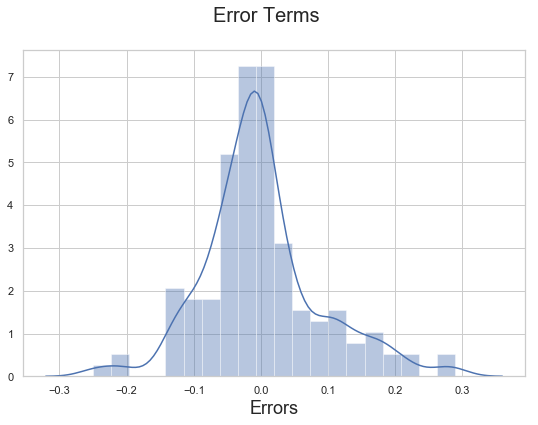

In [566]:
y_train_price = lm_new.predict(x_new)
fig = plt.figure(figsize=(9,6))
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)   
plt.show()

> <span style='color:blue'> 
    **Analyis** - Error terms are distributed around zero which signifies that model prediction is not by chance. <br>
</span>  

# Making Predictions

In [567]:
 car_df_test.head(2)

,symboling,fueltype,aspiration,doornumber,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,hardtop,hatchback,sedan,wagon,five,four,six,three,twelve,two,dohcv,l,ohc,ohcf,ohcv,rotor,2bbl,4bbl,idi,mfi,mpfi,spdi,spfi,Audi,Bmw,Buick,Chevrolet,Dodge,Honda,Isuzu,Jaguar,Mazda,Mercury,Mitsubishi,Nissan,Peugeot,Plymouth,Porsche,Renault,Saab,Subaru,Toyota,Volkswagen,Volvo
160,0,1,1,0,0,1,95.70,166.30,64.40,53.00,2094,98,3.19,3.03,9.00,70,4800,38,47,"7,738.00",0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
186,2,1,1,0,0,1,97.30,171.70,65.50,55.70,2275,109,3.19,3.40,9.00,85,5250,27,34,"8,495.00",0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [568]:
car_df_test[col_to_scale] = scale.transform(car_df_test[col_to_scale])
car_df_test.head(2)

,symboling,fueltype,aspiration,doornumber,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,hardtop,hatchback,sedan,wagon,five,four,six,three,twelve,two,dohcv,l,ohc,ohcf,ohcv,rotor,2bbl,4bbl,idi,mfi,mpfi,spdi,spfi,Audi,Bmw,Buick,Chevrolet,Dodge,Honda,Isuzu,Jaguar,Mazda,Mercury,Mitsubishi,Nissan,Peugeot,Plymouth,Porsche,Renault,Saab,Subaru,Toyota,Volkswagen,Volvo
160,0.40,1,1,0,0,1,0.31,0.41,0.34,0.46,0.24,0.14,0.40,0.42,0.12,0.09,0.27,0.69,0.81,0.07,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
186,0.80,1,1,0,0,1,0.37,0.50,0.43,0.70,0.31,0.18,0.40,0.61,0.12,0.15,0.45,0.39,0.46,0.09,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [569]:
y_test = car_df_test.pop('price')
x_test = car_df_test

In [570]:
final_features = list(x_new.columns)
final_features.remove('const')
print(final_features)

['enginelocation', 'enginesize', 'rotor', 'Bmw']


### Now let's use our model to make predictions.


In [571]:
# Creating X_test_new dataframe by dropping variables from X_test
x_test_new = x_test.filter(final_features)

# Adding a constant variable 
x_test_new = sm.add_constant(x_test_new)

# Making predictions
y_pred = lm_new.predict(x_test_new)

## Model Evaluation

### Calculate the R-squared score on the test dataset

In [572]:
from sklearn.metrics import r2_score 
r2 = r2_score(y_test, y_pred)
log("R-square calculated for test data is : "+str(r2))


> <span style='color:blue'>R-square calculated for test data is : 0.8549789649521333</span>

In [579]:
x_test.head()

,symboling,fueltype,aspiration,doornumber,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,hardtop,hatchback,sedan,wagon,five,four,six,three,twelve,two,dohcv,l,ohc,ohcf,ohcv,rotor,2bbl,4bbl,idi,mfi,mpfi,spdi,spfi,Audi,Bmw,Buick,Chevrolet,Dodge,Honda,Isuzu,Jaguar,Mazda,Mercury,Mitsubishi,Nissan,Peugeot,Plymouth,Porsche,Renault,Saab,Subaru,Toyota,Volkswagen,Volvo
160,0.40,1,1,0,0,1,0.31,0.41,0.34,0.46,0.24,0.14,0.40,0.42,0.12,0.09,0.27,0.69,0.81,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
186,0.80,1,1,0,0,1,0.37,0.50,0.43,0.70,0.31,0.18,0.40,0.61,0.12,0.15,0.45,0.39,0.46,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
59,0.60,1,1,1,0,1,0.42,0.60,0.52,0.52,0.35,0.23,0.56,0.61,0.10,0.15,0.27,0.36,0.41,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
165,0.60,1,1,1,1,1,0.27,0.45,0.31,0.42,0.30,0.14,0.44,0.45,0.15,0.27,1.00,0.36,0.32,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
140,0.80,1,1,1,0,1,0.23,0.26,0.29,0.70,0.29,0.18,0.75,0.23,0.11,0.10,0.10,0.36,0.38,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


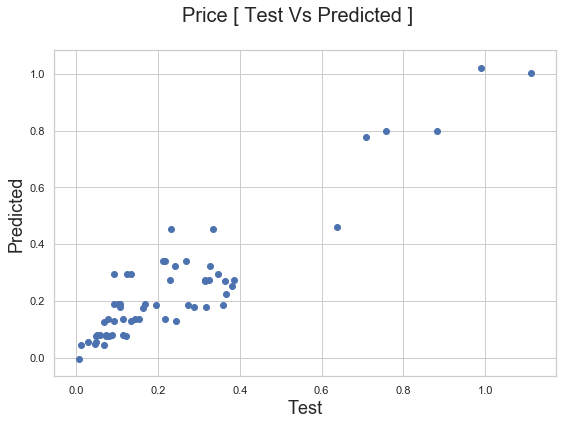

In [581]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure(figsize=(9,6))
plt.scatter(y_test,y_pred)
fig.suptitle('Price [ Test Vs Predicted ]', fontsize=20)              # Plot heading 
plt.xlabel('Test', fontsize=18)                          # X-label
plt.ylabel('Predicted', fontsize=18)                          # Y-label
plt.show()

<span style='color:blue'> **We can see that the equation of our best fitted line is:**<br>

price = 0.2024 - ( 0.2872 * enginelocation ) + (1.1880 * enginesize ) + (0.2516 * rotor) + (0.1988 * Bmw)
</span>                   

### Final Model Summary 

In [582]:
print(lm_new.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     172.3
Date:                Wed, 05 Jun 2019   Prob (F-statistic):           1.27e-52
Time:                        12:40:36   Log-Likelihood:                 144.99
No. Observations:                 143   AIC:                            -280.0
Df Residuals:                     138   BIC:                            -265.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2024      0.093      2.

### Infrences Conclusion

> <span style='color:blue'> **R-sqaured** and **Adjusted R-squared** (extent of fit) - **0.833 and 0.828 - 83%** variance explained.</span>

> <span style='color:blue'>**F-stats and Prob(F-stats)** (overall model fit) - **172.3 and 1.27e-52(approx. 0.0)** - Model fit is significant and explained **83%** variance is just not by chance.</span>

> <span style='color:blue'>**p-values - p-values** for all the coefficients seem to be less than the significance level of **0.05**. - meaning that all the predictors are statistically significant.</span>

> <span style='color:blue'>**AIC and BIC Values -** We can see that there is a diffrence between AIC ( **280.0** ) and BIC ( **265.2** ) fields and BIC has lesser value due to feature penalty and are in range.</span>

> <span style='color:blue'>**Conclusion** : As per final model attributes which are best suited for predicting **Price** are - <br>  1.enginelocation <br>  2.enginesize<br>  3.rotor<br>  4.Bmw<br>
</span>